In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime, timedelta
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import PIL
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error as ase
from sklearn.metrics import confusion_matrix
import IPython.display as ipd

IMG_SHAPE=(28,28)

In [2]:
def read_image(path):
    return PIL.Image.open(path).convert('L')

def extract_image_features(image_folder):
    image_vectors = []
    indices = []
    for image_name in os.listdir(image_folder):
        index = os.path.splitext(image_name)[0]
        indices.append(index)
        image = read_image(os.path.join(image_folder, image_name))
        image_vector = np.array(image).reshape(-1)
        image_vectors.append(image_vector)
    return pd.DataFrame({
        'index': indices,
        'image_vector': image_vectors,
    })

def extract_voice_features(voice_folder, numcep=13, hop_length=256):
    voice_vectors = []
    indices = []
    for record_name in os.listdir(voice_folder):
        index = os.path.splitext(record_name)[0]
        indices.append(index)
        signal, sr = load_wav(
            os.path.join(voice_folder, record_name)
        )
        mfcc_features = librosa.feature.mfcc(
            signal, sr=sr, n_mfcc=numcep, hop_length=hop_length
        )
        voice_vector = mfcc_features.mean(axis=1)
        voice_vectors.append(voice_vector)
    return pd.DataFrame({
        'index': indices,
        'voice_vector': voice_vectors,
    })

def load_wav(path, sr=8000):
    return librosa.load(path, sr=sr)

In [3]:
import zipfile
         
test_zip = zipfile.ZipFile('*your path*\\test.zip')
test_zip.extractall('*your path*\\Test')

test_zip.close()

tr_zip = zipfile.ZipFile('*your path*\\train.zip')
tr_zip.extractall('*your path*\\Train')

tr_zip.close()

In [4]:
IMAGE_TRAIN_PATH = "Train/image"
VOICE_TRAIN_PATH = "Train/voice"
IMAGE_TEST_PATH = "Test/image"
VOICE_TEST_PATH = "Test/voice"

In [5]:
durations = []

min_duration = 10
min_duration_name = ''
max_duration = 0
max_duration_name = ''

for name in os.listdir(VOICE_TRAIN_PATH):
    path = os.path.join(VOICE_TRAIN_PATH, name)
    signal, sr = load_wav(path)
    duration = signal.size / sr
    durations.append(duration)
    if duration < min_duration:
        min_duration, min_duration_name = duration, name

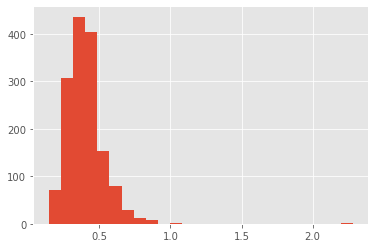

In [6]:
plt.hist(durations, bins=25);

In [7]:
dur=max(durations)
for i in range(0,len(durations)):
    durations[i]=durations[i]/dur

In [8]:
ll=[]
for i in range(0,len(durations)):
    ll.append([durations[i]])
ll=np.array(ll)

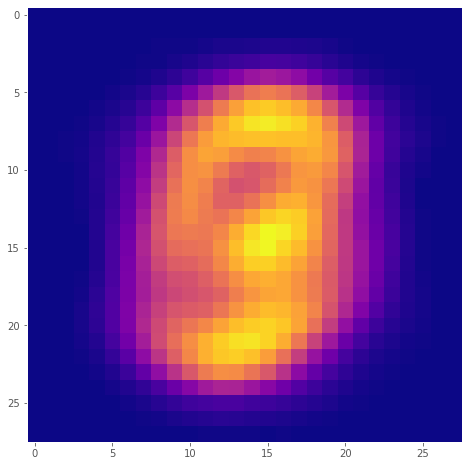

In [9]:
sum_intensity = np.zeros(IMG_SHAPE, dtype=np.float32)

zero_element_counts = []
target = [] 

max_zero = -1
min_zero = 28 * 28 + 1
min_zero_name = ''
max_zero_name = ''

for i, name in enumerate(os.listdir(IMAGE_TRAIN_PATH)):
    path = os.path.join(IMAGE_TRAIN_PATH, name)
    target.append(int(name[0]))
    img = read_image(path)
    np_img = np.array(img)
    zero_count = (np_img < 1.0).astype(int).sum()
    zero_element_counts.append(zero_count)
    
    if zero_count > max_zero:
        max_zero, max_zero_name = zero_count, name

    if zero_count < min_zero:
        min_zero, min_zero_name = zero_count, name 
        
    sum_intensity += np_img
    if i % 10 == 0:
        ipd.clear_output(wait=True)
        plt.figure(figsize=(8,8))
        plt.imshow(sum_intensity, cmap="plasma")
        plt.grid(False)
        plt.show()

In [10]:
zerosm=max(zero_element_counts)
for i in range(0,len(zero_element_counts)):
    zero_element_counts[i]=zero_element_counts[i]/zerosm

In [11]:
zrk=[]
for i in range(0,len(zero_element_counts)):
    zrk.append([zero_element_counts[i]])
zrk=np.array(zrk)

In [12]:
voice_features = extract_voice_features(VOICE_TRAIN_PATH)
image_features = extract_image_features(IMAGE_TRAIN_PATH)
dataset = image_features.merge(voice_features, on='index')
dataset["target"] = dataset["index"].apply(lambda x: int(x[0]))
dataset["dur"]=ll
dataset["zeros"]=zrk

In [13]:
#dataset

In [14]:
#ll=np.vstack(dataset["dur"])
#zrk=np.vstack(dataset["zeros"])
def del_zeros(mat,l1,l2):
    remove=[]
    for i in range(0,l2):
        if any(mat[:, i])==False:
            
            remove.append(i)
    return remove

In [15]:
train_data, test_data = train_test_split(dataset,test_size=0.2, random_state = 142)
y_train=train_data["target"].values
y_test=test_data["target"].values

In [16]:
p1=np.vstack(train_data["image_vector"])
p2=np.vstack(train_data["voice_vector"])
ll1=np.vstack(train_data["dur"])
zers=np.vstack(train_data["zeros"])
union1=np.hstack((p1,p2))
union1=np.hstack((union1,ll1))
union1=np.hstack((union1,zers))

X_train=union1

In [17]:
part1=np.vstack(test_data["image_vector"])
part2=np.vstack(test_data["voice_vector"])
ll2=np.vstack(test_data["dur"])
zs=np.vstack(test_data["zeros"])
uni1=np.hstack((part1,part2))
uni2=np.hstack((uni1,ll2))
union2=np.hstack((uni2,zs))

X_test=union2

In [18]:
#from sklearn.ensemble import BaggingClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import classification_report, f1_score, roc_auc_score

In [19]:
#tree_clf = DecisionTreeClassifier(max_depth=100, random_state=27)
#bagging_clf = BaggingClassifier(base_estimator=tree_clf, n_estimators=1000, random_state=0)
#bagging_clf.fit(X_train, y_train)

In [20]:
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.experimental import enable_hist_gradient_boosting
#from sklearn.ensemble import HistGradientBoostingClassifier
#clf =AdaBoostClassifier(n_estimators=1000,random_state = 10)
#RandomForestClassifier(n_estimators=2000, random_state = 142),)
#clf=RandomForestClassifier(n_estimators=2000, random_state = 142)
clf=GradientBoostingClassifier(n_estimators=400, random_state = 5)
#clf=ExtraTreesClassifier(n_estimators=1000, random_state=5)
#clf = HistGradientBoostingClassifier(max_depth=80, learning_rate=1)
clf.fit(X_train, y_train)
y = clf.predict(X_train)

In [21]:
ase(y,y_train)

0.0

In [22]:
rf_clf = RandomForestClassifier(max_depth=20, n_estimators=2000, max_features=90,
                                class_weight = 'balanced')
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=90,
                       n_estimators=2000)

In [23]:
y1=rf_clf.predict(X_test)

In [24]:
ase(y1,y_test)

0.08666666666666667

In [25]:
durations = []

min_duration = 10
min_duration_name = ''
max_duration = 0
max_duration_name = ''

for name in os.listdir(VOICE_TEST_PATH):
    path = os.path.join(VOICE_TEST_PATH, name)
    signal, sr = load_wav(path)
    duration = signal.size / sr
    durations.append(duration)
    if duration < min_duration:
        min_duration, min_duration_name = duration, name

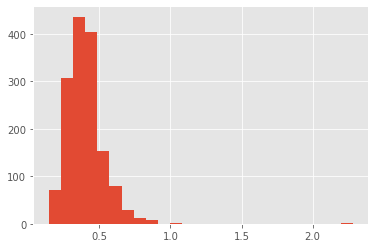

In [26]:
plt.hist(durations, bins=25);

In [27]:
ll=[]
for i in range(0,len(durations)):
    ll.append([durations[i]])
ll=np.array(ll)

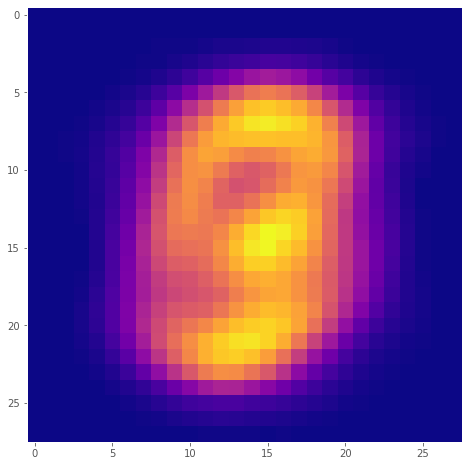

In [28]:
sum_intensity = np.zeros(IMG_SHAPE, dtype=np.float32)

zero_element_counts = []
target = [] 

max_zero = -1
min_zero = 28 * 28 + 1
min_zero_name = ''
max_zero_name = ''

for i, name in enumerate(os.listdir(IMAGE_TEST_PATH)):
    path = os.path.join(IMAGE_TEST_PATH, name)
    target.append(int(name[0]))
    img = read_image(path)
    np_img = np.array(img)
    zero_count = (np_img < 1.0).astype(int).sum()
    zero_element_counts.append(zero_count)
    
    if zero_count > max_zero:
        max_zero, max_zero_name = zero_count, name

    if zero_count < min_zero:
        min_zero, min_zero_name = zero_count, name 
        
    sum_intensity += np_img
    if i % 10 == 0:
        ipd.clear_output(wait=True)
        plt.figure(figsize=(8,8))
        plt.imshow(sum_intensity, cmap="plasma")
        plt.grid(False)
        plt.show()

In [29]:
zrk=[]
for i in range(0,len(zero_element_counts)):
    zrk.append([zero_element_counts[i]])
zrk=np.array(zrk)

In [30]:
submit_image_features = extract_image_features(IMAGE_TEST_PATH)
submit_voice_features = extract_voice_features(VOICE_TEST_PATH)
submit_dataset = submit_image_features.merge(
    submit_voice_features,
    on="index"
)
submit_dataset["index"] = submit_dataset["index"].apply(int)
submit_dataset["dur"]=ll
submit_dataset["zeros"]=zrk

In [31]:
X1=np.vstack(submit_dataset["image_vector"])
X2=np.vstack(submit_dataset["voice_vector"])
xl=np.vstack(submit_dataset["dur"])
xz=np.vstack(submit_dataset["zeros"])
XX=np.hstack((X1,X2))
XX=np.hstack((XX,xl))
XX=np.hstack((XX,xz))
#XX=np.delete(XX, remove, axis=1)

In [32]:
#ans=clf.predict(XX)
ans=rf_clf.predict(XX)
submit_dataset["target"] = ans

In [33]:
submit_dataset[["index", "target"]] \
    .sort_values("index") \
    .to_csv("submit.csv", index=False)

# Поиск слабых мест модели

In [34]:
#y_pred = clf.predict(X_test)
y_pred = rf_clf.predict(X_test)

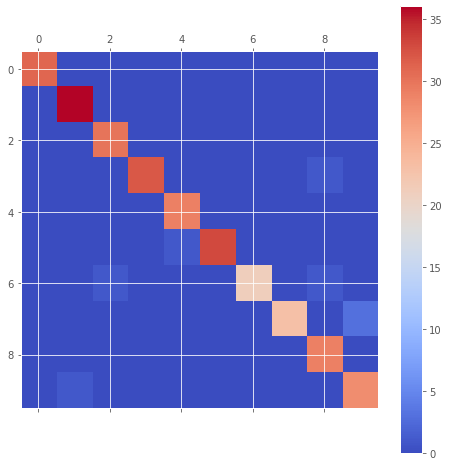

In [35]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
plt.matshow(conf_matrix, cmap="coolwarm", fignum=1)
plt.colorbar();

In [36]:
test_data["predict"] = y_pred

In [37]:
wrong = test_data[test_data["target"] != test_data["predict"]]

In [38]:
len(wrong)

8

In [39]:
wrong_subset = wrong[:25]

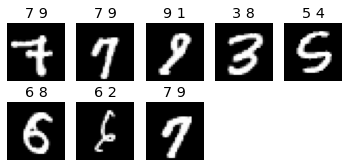

In [40]:
printed = 0

plt.figure(figsize=(6, 7))
for i, row in wrong_subset.iterrows():
    name = row["index"] + ".png"
    img = read_image(os.path.join(IMAGE_TRAIN_PATH, name))
    plt.subplot(5, 5, printed+1)
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.title(f"{row['target']} {row['predict']}")
    plt.axis('off')
    printed += 1